## 0. Current Process on Building Class "analyzer"

This shows the current work process on building new class "analyzer", by now the initialization part and first two features are done. **a copy of code below is stored into analyzer.py to test how it runs on terminal**

In [25]:
import os
import datetime as dt
import pandas as pd
import requests
import tarfile
import matplotlib.pyplot as plt
import ast  # Import for parsing dictionary-like strings


class MovieAnalyzer:
    """
    A class to perform three kinds of quick analysis for movie data from CMU dataset. By calling the built-in methods,
    the analyzer object can generate indicated pandas DataFrame, and return plot generated by matplotlib(if possible).
    

    Attributes
    ----------
    data_dir : str
        default directory for storing datasets.
    movie_data_file : str
        default path for storing 'movie.metadata.tsv' extracted from zipped file.
    movies_df: pandas.DataFrame
        DataFrame of movie data loaded from 'movie.metadata.tsv'
    character_data_file : str
        default path for storing character.metadata.tsv extracted from zipped file.
    characters_df : pandas.DataFrame
        DataFrame of character data loaded fron 'character.metadata.tsv' 

    Methods
    -------
    download_and_extract(self):
        A static method inside class to download target dataset
    movie_type(self, N):
        Return a panda.Series showing how many times a genre in top N genres shows up in the database.
    actor_count(self):
        Return a histogram of "number of actors" vs "movie counts". 
    actor_distributions(self, gender, max_height, min_height):
        Return an actor data in pandas.DataFrame under 3 given conditions or plot the distribution of filtered actorData.
    """

    @staticmethod
    def parse_genres(x):
        """Convert stringified dictionaries into real Python dicts (handle errors safely)"""
        try:
            return ast.literal_eval(x) if isinstance(x, str) else {}
        except (SyntaxError, ValueError):
            return {}

    @staticmethod    
    def download_and_extract():
        """Download dataset if not present and extract it."""
        url = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
        tar_path = os.path.join("data", "MovieSummaries.tar.gz")

        if not os.path.exists(tar_path):
            print("Downloading dataset...")
            response = requests.get(url, stream=True)
            with open(tar_path, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)

        print("Extracting dataset...")
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall("data/")  # ✅ Extract correctly into 'data/MovieSummaries/'
    
    
    def __init__(self):
        """Initialize the class by checking for dataset and loading it."""
        self.data_dir = "data/MovieSummaries/"
        os.makedirs(self.data_dir, exist_ok=True)

        # Dataset file paths
        self.movie_data_file = os.path.join(self.data_dir, "movie.metadata.tsv")
        self.character_data_file = os.path.join(self.data_dir, "character.metadata.tsv")

        # Check if datasets exist; if not, download and extract them
        if not os.path.exists(self.movie_data_file) or not os.path.exists(
            self.character_data_file
        ):
            self.download_and_extract()

        # Load datasets
        self.movies_df = pd.read_csv(
            self.movie_data_file,
            sep="\t",
            header=None,
            names=[
                "wiki_movie_id",
                "freebase_movie_id",
                "movie_name",
                "release_date",
                "box_office",
                "runtime",
                "languages",
                "countries",
                "genres",
            ],
        )

        self.characters_df = pd.read_csv(
            self.character_data_file,
            sep="\t",
            header=None,
            names=[
                "wiki_movie_id",
                "freebase_movie_id",
                "release_date",
                "character_name",
                "actor_dob",
                "actor_gender",
                "actor_height",
                "actor_ethnicity",
                "actor_name",
                "actor_age",
                "char_actor_map_id",
                "char_id",
                "actor_id",
            ],
        )



    def movie_type(self, N: int = 10) -> pd.DataFrame:
        """
        Returns the N most common movie genres.

        Parameters
        -----------
            self: class
                The MovieAnalyzer class itself
            N: int
                Show only top N genre

        Returns
        --------
            pandas.DataFrame: The movie type counts data

        """
        if not isinstance(N, int):
            raise ValueError("N must be an integer.")

        self.movies_df["genres"] = self.movies_df["genres"].apply(self.parse_genres)

        # Extract genre names
        all_genres = []
        for genre_dict in self.movies_df["genres"].dropna():
            if isinstance(genre_dict, dict):
                all_genres.extend(genre_dict.values())  # Extract genre names

        # Create a DataFrame counting occurrences of each genre
        genre_counts = (
            pd.DataFrame({"Movie_Type": all_genres}).value_counts().reset_index()
        )
        genre_counts.columns = ["Movie_Type", "Count"]

        return genre_counts.head(N)

    def actor_count(self) -> pd.DataFrame:
        """
        Plots a histogram data of actors per movie.
        
        Returns
        -----------
        matplotlib.pyplot.figure: A figure showing the histogram

        """
        actor_counts = (
            self.characters_df.groupby("wiki_movie_id")
            .size()
            .value_counts()
            .reset_index()
        )
        actor_counts.columns = ["Number_of_Actors", "Movie_Count"]
        return actor_counts

    def actor_distributions(
        self,
        gender: str = "All",
        max_height: float = 2.5,
        min_height: float = 1.0,
        plot: bool = False,
    ) -> pd.DataFrame:
        """
        Calculate a non-duplicated actor data with actors' name, gender and height under three search conditions. 
        Set `plot` to true to plot histogram.

        Parameters
        -----------
        self: class
            The MovieAnalyzer class itself
        gender: str
            "All" or specific gender ("Male", "Female", etc.).
        max_height: float
            Maximum actor height.
        min_height: float 
            Minimum actor height.
        plot: boolean
            If True, plots the height distribution.
        
        Returns
        -------- 
            pandas.DataFrame: Filtered DataFrame with actor names, gender, and height.
            matplotlib.pylot.figure: A figure showing the distribution in histogram

        Raises ValueError: If gender is not a string or height values are not numeric.
        """

        # Validate input types
        if not isinstance(gender, str):
            raise ValueError("Gender must be a string ('All', 'Male', 'Female', etc.).")

        if not isinstance(max_height, (int, float)) or not isinstance(
            min_height, (int, float)
        ):
            raise ValueError("Height values must be numeric.")

        if max_height < min_height:
            raise ValueError("max_height must be greater than min_height.")

        # Convert 'M' -> 'Male', 'F' -> 'Female' in the dataset
        self.characters_df["actor_gender"] = self.characters_df["actor_gender"].replace(
            {"M": "Male", "F": "Female"}
        )

        # Filter dataset based on height
        df = self.characters_df.dropna(
            subset=["actor_height"]
        )  # Remove missing heights
        df = df[(df["actor_height"] >= min_height) & (df["actor_height"] <= max_height)]

        # Get distinct non-missing gender values
        valid_genders = df["actor_gender"].dropna().unique().tolist()

        # Validate gender input
        if gender != "All" and gender not in valid_genders:
            raise ValueError(f"Invalid gender. Choose from {valid_genders} or 'All'.")

        # Filter by gender if not "All"
        if gender != "All":
            df = df[df["actor_gender"] == gender]

        # Plot if requested
        if plot:
            plt.figure(figsize=(8, 5))
            plt.hist(
                df["actor_height"].dropna(),
                bins=20,
                alpha=0.7,
                color="skyblue",
                edgecolor="black",
            )
            plt.xlabel("Height (m)")
            plt.ylabel("Frequency")
            plt.title(f"Actor Height Distribution - Gender: {gender}")
            plt.grid(axis="y", linestyle="--", alpha=0.7)

            # ✅ Ensure the plot is rendered in Streamlit
            import streamlit as st

            st.pyplot(plt)

        return df[["actor_name", "actor_gender", "actor_height"]]
    
    def releases(self, genre: str = None) -> pd.DataFrame:
        # Use static method to parse genres and form lists
        self.movies_df["genres"] = self.movies_df["genres"].apply(self.parse_genres)
        self.movies_df["genres"] = self.movies_df["genres"].apply(lambda x: list(x.values()))

        # Extract year from "Release Date"
        self.movies_df["release_year"] = pd.to_datetime(self.movies_df["release_date"], format="%Y-%m-%d", errors="coerce")
        self.movies_df["release_year"] = self.movies_df["release_year"].dt.strftime("%Y")
        # If no genre given, group movies directly
        if genre == None:
            releases_grouped = self.movies_df.groupby("release_year")

        # if a genre is given, search for matched movies then group them
        else:
            releases_grouped = self.movies_df[self.movies_df["genres"].apply(lambda x: genre in x)].groupby("release_year")

        releases = releases_grouped.size().reset_index()
        releases_columns = {"release_year": "Release Year", 0: "Number of Movies"}

        return releases.rename(columns=releases_columns)
    
    def ages(self, scale: str = "Y"):
        if scale != "Y" and scale != "M":
            scale = "Y"
        
        # Extract year and month from "actor_dob"
        self.characters_df["actor_birth_year"] = pd.to_datetime(self.characters_df["actor_dob"], format="%Y-%m-%d", errors="coerce")
        self.characters_df["actor_birth_year"] = self.characters_df["actor_birth_year"].dt.strftime("%Y")

        self.characters_df["actor_birth_month"] = pd.to_datetime(self.characters_df["actor_dob"], format="%Y-%m-%d", errors="coerce")
        self.characters_df["actor_birth_month"] = self.characters_df["actor_birth_month"].dt.strftime("%B")

        # scale set to "Y"
        if scale == "Y":
            ages_grouped = self.characters_df.groupby("actor_birth_year")
            ages = ages_grouped.size().reset_index()

            ages.columns = ["Year", "Number of Births"]

        # if scale set to "M"
        if scale == "M":
            month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
            ages_grouped = self.characters_df.groupby("actor_birth_month")
            ages = ages_grouped.size().reset_index()

            ages["actor_birth_month"] = pd.Categorical(ages["actor_birth_month"], categories=month_order, ordered=True) 
            ages.columns = ["Month", "Number of Births"]

            ages = ages.sort_values("Month").reset_index(drop=True)

        return ages

In [27]:
MovieAnalyzer().ages("Y")

Year  Number of Births
0    1796                 1
1    1828                 1
2    1829                 1
3    1835                 2
4    1836                 2
..    ...               ...
171  2005                 1
172  2006                 7
173  2007                 1
174  2008                 5
175  2011                10

[176 rows x 2 columns]

In [ ]:
analyzer().actor_distributions()

Connceting to the datasets ...
Successfully connected to the datasets


Movie_Type
Comedy             16349
Romance Film       10234
Black-and-white     9094
Action              8798
Thriller            8744
Short Film          8141
World cinema        7155
Crime Fiction       6948
Indie               6897
Name: count, dtype: int64

## 1. Finding solutions for required features in Jupyter environment

This part is used to load data, process them, and get ideal result as usual in a .ipynb environment. `dfm` and `dfc` are correctly loaded movie data and character data (same as those in the class "analyzer")

In [ ]:
dfm=pd.read_csv("..\\data\\MovieSummaries\\movie.metadata.tsv", 
               sep="\t", 
               names=['wikiID', 'fbID', 'movieName', 'releaseDate', 'boxRevenue', 'runtime', 'language', 'country', 'genre'])

In [ ]:
def parse_genres(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else {}
    except (SyntaxError, ValueError):
        return {}

In [ ]:
dfm.genre=dfm.genre.apply(parse_genres).apply(lambda x: list(x.values()))

In [ ]:
dfm[dfm["genre"].apply(lambda x: "Horror" in x)]

wikiID        fbID           movieName releaseDate  boxRevenue  \
0        975900   /m/03vyhn      Ghosts of Mars  2001-08-24  14010832.0   
9       2345652   /m/075f66    City of the Dead        1960         NaN   
33     27611999  /m/04j284s     Special Effects        1984         NaN   
72     20334086  /m/04zyc0t              Vipers  2008-09-21         NaN   
77      1254263   /m/04mhwd             Shivers  1975-10-10         NaN   
...         ...         ...                 ...         ...         ...   
81660  30748966  /m/0gfgs5h             Haunted  2011-05-06         NaN   
81707  30863646   /m/05hlhc          Mondo Cane        1962         NaN   
81722  26044505  /m/0b6m67n  The Flying Serpent        1946         NaN   
81728   3868432   /m/0b44p5     Into the Mirror  2003-08-14         NaN   
81740  12476867  /m/02w7zz8             Spliced        2002         NaN   

       runtime                                           language  \
0         98.0                 {"/m/02h40lc": "English Language"}   
9         76.0                 {"/m/02h40lc": "English Language"}   
33        93.0                                                 {}   
72        89.0                                                 {}   
77        89.0                 {"/m/02h40lc": "English Language"}   
...        ...                                                ...   
81660    143.0  {"/m/03k50": "Hindi Language", "/m/02h40lc": "...   
81707    108.0                 {"/m/02bjrlw": "Italian Language"}   
81722     59.0                                                 {}   
81728    113.0                  {"/m/02hwhyv": "Korean Language"}   
81740     86.0                 {"/m/02h40lc": "English Language"}   

                                                 country  \
0              {"/m/09c7w0": "United States of America"}   
9                         {"/m/07ssc": "United Kingdom"}   
33     {"/m/09c7w0": "United States of America", "/m/...   
72             {"/m/09c7w0": "United States of America"}   
77                               {"/m/0d060g": "Canada"}   
...                                                  ...   
81660                              {"/m/03rk0": "India"}   
81707                              {"/m/03rjj": "Italy"}   
81722          {"/m/09c7w0": "United States of America"}   
81728                        {"/m/06qd3": "South Korea"}   
81740                            {"/m/0d060g": "Canada"}   

                                                   genre  
0      [Thriller, Science Fiction, Horror, Adventure,...  
9                                 [Horror, Supernatural]  
33     [Thriller, Horror, Psychological thriller, Sus...  
72                            [Horror, Television movie]  
77     [Science Fiction, Horror, Erotica, Sci-Fi Horr...  
...                                                  ...  
81660                        [Thriller, Mystery, Horror]  
81707  [Culture & Society, Horror, Mondo film, World ...  
81722                        [Thriller, B-movie, Horror]  
81728                                           [Horror]  
81740                  [Thriller, Horror, Slasher, Teen]  

[5280 rows x 9 columns]

In [ ]:
dfm["releaseDate"].str[0:4].value_counts()

releaseDate
2008    2465
2006    2434
2007    2389
2009    2247
2005    2102
        ... 
1904       1
1893       1
1889       1
1888       1
1010       1
Name: count, Length: 130, dtype: int64

In [ ]:
pd.to_datetime(dfm["releaseDate"], format="%Y-%m-%d", errors="coerce")

0       2001-08-24
1       2000-02-16
2              NaT
3              NaT
4              NaT
           ...    
81736   2011-03-19
81737   2011-01-21
81738   1972-09-22
81739   1992-05-21
81740          NaT
Name: releaseDate, Length: 81741, dtype: datetime64[ns]

In [ ]:
exploded_df

wikiID        fbID  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   
2      28463795  /m/0crgdbh   
3       9363483  /m/0285_cd   
4        261236   /m/01mrr1   
...         ...         ...   
81736  35228177  /m/0j7hxnt   
81737  34980460  /m/0g4pl34   
81738   9971909  /m/02pygw1   
81739    913762   /m/03pcrp   
81740  12476867  /m/02w7zz8   

                                               movieName releaseDate  \
0                                         Ghosts of Mars  2001-08-24   
1      Getting Away with Murder: The JonBenét Ramsey ...  2000-02-16   
2                                            Brun bitter        1988   
3                                       White Of The Eye        1987   
4                                      A Woman in Flames        1983   
...                                                  ...         ...   
81736                           Mermaids: The Body Found  2011-03-19   
81737                                            Knuckle  2011-01-21   
81738                                  Another Nice Mess  1972-09-22   
81739  The Super Dimension Fortress Macross II: Lover...  1992-05-21   
81740                                            Spliced        2002   

       boxRevenue  runtime                            language  \
0      14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1             NaN     95.0  {"/m/02h40lc": "English Language"}   
2             NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3             NaN    110.0  {"/m/02h40lc": "English Language"}   
4             NaN    106.0   {"/m/04306rv": "German Language"}   
...           ...      ...                                 ...   
81736         NaN    120.0  {"/m/02h40lc": "English Language"}   
81737         NaN     96.0  {"/m/02h40lc": "English Language"}   
81738         NaN     66.0  {"/m/02h40lc": "English Language"}   
81739         NaN    150.0   {"/m/03_9r": "Japanese Language"}   
81740         NaN     86.0  {"/m/02h40lc": "English Language"}   

                                                 country genre  
0              {"/m/09c7w0": "United States of America"}   NaN  
1              {"/m/09c7w0": "United States of America"}   NaN  
2                                 {"/m/05b4w": "Norway"}   NaN  
3                         {"/m/07ssc": "United Kingdom"}   NaN  
4                                {"/m/0345h": "Germany"}   NaN  
...                                                  ...   ...  
81736          {"/m/09c7w0": "United States of America"}   NaN  
81737  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   NaN  
81738          {"/m/09c7w0": "United States of America"}   NaN  
81739                              {"/m/03_3d": "Japan"}   NaN  
81740                            {"/m/0d060g": "Canada"}   NaN  

[81741 rows x 9 columns]

In [ ]:
dfm

wikiID        fbID  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   
2      28463795  /m/0crgdbh   
3       9363483  /m/0285_cd   
4        261236   /m/01mrr1   
...         ...         ...   
81736  35228177  /m/0j7hxnt   
81737  34980460  /m/0g4pl34   
81738   9971909  /m/02pygw1   
81739    913762   /m/03pcrp   
81740  12476867  /m/02w7zz8   

                                               movieName releaseDate  \
0                                         Ghosts of Mars  2001-08-24   
1      Getting Away with Murder: The JonBenét Ramsey ...  2000-02-16   
2                                            Brun bitter        1988   
3                                       White Of The Eye        1987   
4                                      A Woman in Flames        1983   
...                                                  ...         ...   
81736                           Mermaids: The Body Found  2011-03-19   
81737                                            Knuckle  2011-01-21   
81738                                  Another Nice Mess  1972-09-22   
81739  The Super Dimension Fortress Macross II: Lover...  1992-05-21   
81740                                            Spliced        2002   

       boxRevenue  runtime                            language  \
0      14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1             NaN     95.0  {"/m/02h40lc": "English Language"}   
2             NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3             NaN    110.0  {"/m/02h40lc": "English Language"}   
4             NaN    106.0   {"/m/04306rv": "German Language"}   
...           ...      ...                                 ...   
81736         NaN    120.0  {"/m/02h40lc": "English Language"}   
81737         NaN     96.0  {"/m/02h40lc": "English Language"}   
81738         NaN     66.0  {"/m/02h40lc": "English Language"}   
81739         NaN    150.0   {"/m/03_9r": "Japanese Language"}   
81740         NaN     86.0  {"/m/02h40lc": "English Language"}   

                                                 country  \
0              {"/m/09c7w0": "United States of America"}   
1              {"/m/09c7w0": "United States of America"}   
2                                 {"/m/05b4w": "Norway"}   
3                         {"/m/07ssc": "United Kingdom"}   
4                                {"/m/0345h": "Germany"}   
...                                                  ...   
81736          {"/m/09c7w0": "United States of America"}   
81737  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
81738          {"/m/09c7w0": "United States of America"}   
81739                              {"/m/03_3d": "Japan"}   
81740                            {"/m/0d060g": "Canada"}   

                                                   genre  
0      [Thriller, Science Fiction, Horror, Adventure,...  
1       [Mystery, Biographical film, Drama, Crime Drama]  
2                                 [Crime Fiction, Drama]  
3      [Thriller, Erotic thriller, Psychological thri...  
4                                                [Drama]  
...                                                  ...  
81736                                            [Drama]  
81737            [Biographical film, Drama, Documentary]  
81738                                   [Satire, Comedy]  
81739  [Science Fiction, Japanese Movies, Adventure, ...  
81740                  [Thriller, Horror, Slasher, Teen]  

[81741 rows x 9 columns]

In [ ]:
dfc=pd.read_csv("..\\data\\MovieSummaries\\character.metadata.tsv", 
               sep="\t", 
               names=['wikiID', 'fbID', 'releaseDate', 'characterName', 'actorBirthday', 'actorGender', 'actorHeight',
                      'actorEthnicityID','actorName', 'ageAtRelease', 'fbMapID', 'fbCharacterID','fbActorID'])

In [ ]:
sorted(dfc.actorHeight.unique())

[np.float64(0.61),
 np.float64(1.524),
 np.float64(1.55),
 np.float64(1.56),
 np.float64(1.57),
 np.float64(1.575),
 np.float64(1.59),
 np.float64(1.6),
 np.float64(1.6002),
 np.float64(1.61),
 np.float64(1.62),
 np.float64(1.626),
 np.float64(1.63),
 np.float64(1.64),
 np.float64(1.65),
 np.float64(1.67),
 np.float64(1.676),
 np.float64(1.68),
 np.float64(1.715),
 np.float64(1.727),
 np.float64(1.75),
 np.float64(1.753),
 np.float64(1.78),
 np.float64(nan),
 np.float64(0.813),
 np.float64(0.83),
 np.float64(0.88),
 np.float64(0.94),
 np.float64(1.0),
 np.float64(1.06),
 np.float64(1.067),
 np.float64(1.07),
 np.float64(1.09728),
 np.float64(1.1176),
 np.float64(1.12),
 np.float64(1.14),
 np.float64(1.143),
 np.float64(1.168),
 np.float64(1.17),
 np.float64(1.19),
 np.float64(1.194),
 np.float64(1.21),
 np.float64(1.219),
 np.float64(1.22),
 np.float64(1.23),
 np.float64(1.24),
 np.float64(1.262),
 np.float64(1.27),
 np.float64(1.29),
 np.float64(1.3),
 np.float64(1.32),
 np.float64(1.

In [ ]:
dfc.head()

wikiID       fbID releaseDate               characterName actorBirthday  \
0  975900  /m/03vyhn  2001-08-24                    Akooshay    1958-08-26   
1  975900  /m/03vyhn  2001-08-24  Lieutenant Melanie Ballard    1974-08-15   
2  975900  /m/03vyhn  2001-08-24         Desolation Williams    1969-06-15   
3  975900  /m/03vyhn  2001-08-24          Sgt Jericho Butler    1967-09-12   
4  975900  /m/03vyhn  2001-08-24             Bashira Kincaid    1977-09-25   

  actorGender  actorHeight actorEthnicityID           actorName  ageAtRelease  \
0           F        1.620              NaN      Wanda De Jesus          42.0   
1           F        1.780       /m/044038p  Natasha Henstridge          27.0   
2           M        1.727          /m/0x67            Ice Cube          32.0   
3           M        1.750              NaN       Jason Statham          33.0   
4           F        1.650              NaN         Clea DuVall          23.0   

      fbMapID fbCharacterID   fbActorID  
0  /m/0bgchxw    /m/0bgcj3x  /m/03wcfv7  
1   /m/0jys3m    /m/0bgchn4   /m/0346l4  
2   /m/0jys3g    /m/0bgchn_  /m/01vw26l  
3  /m/02vchl6    /m/0bgchnq   /m/034hyc  
4  /m/02vbb3r    /m/0bgchp9   /m/01y9xg

In [ ]:
dfc.actorBirthday.isnull().value_counts()

actorBirthday
False    344524
True     106145
Name: count, dtype: int64

In [ ]:
for x in dfc.actorBirthday.str[0:4]:
    print(x)

1958
1974
1969
1967
1977
1949
1945
nan
1971
nan
nan
1959
1944
nan
1935
1954
1943
nan
1956
nan
nan
1950
1945
1959
1964
1994
1959
1937
nan
nan
1949
nan
1954
1959
1947
1957
1950
1950
1947
nan
1959
1974
nan
1998
nan
1966
1988
1989
1959
1941
nan
nan
1960
nan
1970
1974
1971
1961
1963
1974
1977
1975
1947
1892
1897
1933
1947
1940
1935
1939
1954
1906
1894
1907
1901
1952
1975
1943
1955
1952
1960
1972
nan
nan
1909
nan
1899
nan
nan
nan
nan
nan
nan
1887
nan
1902
1915
1899
1888
1903
1970
1978
nan
1965
nan
nan
nan
1961
1934
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1971
nan
1962
nan
nan
nan
1967
nan
nan
nan
1970
nan
1983
1959
1963
nan
nan
1976
1969
1960
1958
1940
1960
1951
1955
1941
1948
nan
1976
1979
1981
1977
nan
nan
1975
nan
1953
1982
nan
nan
nan
nan
1962
nan
nan
1949
1955
1942
1951
1943
nan
nan
1955
1963
nan
nan
1960
1959
1948
1958
1974
1969
nan
nan
nan
1931
nan
nan
1929
1921
1947
nan
nan
1945
1944
1971
1891
1864
1867
1860
1861
1875
1882
1887
1931
1921
1931
1946
1956
nan
1941
1972
nan
nan
1957
1942

In [ ]:
dfa=dfc[["actorName", "actorGender", "actorHeight"]].drop_duplicates()
dfa.drop_duplicates()['actorGender'].value_counts()

actorGender
M    60922
F    35720
Name: count, dtype: int64

In [ ]:
df_ac=dfm[["wikiID", "movieName"]].join(dfc['wikiID'].value_counts().astype("Int64"), on="wikiID")
df_ac.rename(columns={"count": "actorCounts"}, inplace=True)

<Axes: xlabel='actorCounts', ylabel='Count'>

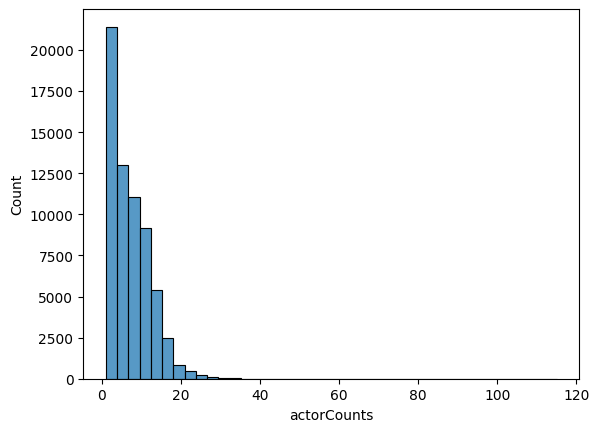

In [ ]:
sns.histplot(data=df_ac,x="actorCounts",bins=40)

In [ ]:
dfm["genre"].apply(lambda x: list(ast.literal_eval(x).values())).explode(ignore_index=True).value_counts()[0:10]

genre
Drama              34007
Comedy             16349
Romance Film       10234
Black-and-white     9094
Action              8798
Thriller            8744
Short Film          8141
World cinema        7155
Crime Fiction       6948
Indie               6897
Name: count, dtype: int64

In [ ]:
dfm.releaseDate.str[0:4]

0        2001
1        2000
2        1988
3        1987
4        1983
         ... 
81736    2011
81737    2011
81738    1972
81739    1992
81740    2002
Name: releaseDate, Length: 81741, dtype: object

In [ ]:
dfm.genre=dfm.genre.apply(lambda x: list(ast.literal_eval(x).values()))
#df.language=df.language.apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)